# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [18]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [4]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [5]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([[-10, 0, 10]]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([[1000, 0, 0]]))
assert np.isclose(probs[0][0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [94]:
loss = nn.CrossEntropyLoss()
input = torch.tensor([[-5., 5., 0.], [3., -2., 7.]])
ind = torch.tensor([1, 2])

In [95]:
loss(input, ind)

tensor(0.0125)

In [68]:
probs = linear_classifer.softmax(np.array([[-5, 5, 0], [3, -2, 7]]))
linear_classifer.cross_entropy_loss(probs, np.array([1, 2]))

0.012515777125719649

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [88]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([[1, 2, 2],[3, 0, -1]]), np.array([[1], [0]]))
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, np.array([[1], [0]])), np.array(np.array([[1, 2, 2],[3, 0, -1]]), np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [61]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [5]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [96]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [97]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 2.397260
Epoch 1, loss: 2.330214
Epoch 2, loss: 2.310426
Epoch 3, loss: 2.304377
Epoch 4, loss: 2.302885
Epoch 5, loss: 2.302995
Epoch 6, loss: 2.302474
Epoch 7, loss: 2.301422
Epoch 8, loss: 2.302158
Epoch 9, loss: 2.301547


In [63]:
pred = classifier.predict(val_X)

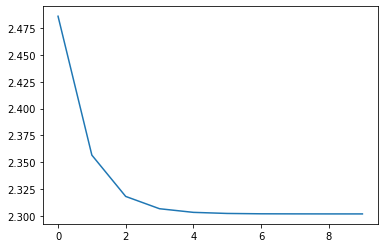

In [71]:
plt.plot(loss_history)

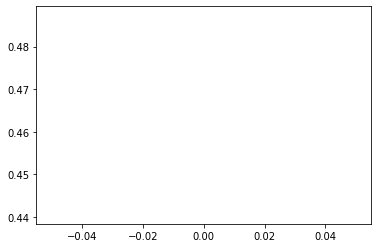

In [65]:
# let's look at the loss history!
plt.plot(loss)

In [66]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
loss = classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.127
Epoch 0, loss: 2.301800
Epoch 1, loss: 2.302558
Epoch 2, loss: 2.302208
Epoch 3, loss: 2.303309
Epoch 4, loss: 2.302126
Epoch 5, loss: 2.301524
Epoch 6, loss: 2.301150
Epoch 7, loss: 2.301359
Epoch 8, loss: 2.302305
Epoch 9, loss: 2.302205
Epoch 10, loss: 2.301595
Epoch 11, loss: 2.302039
Epoch 12, loss: 2.301247
Epoch 13, loss: 2.301836
Epoch 14, loss: 2.302396
Epoch 15, loss: 2.302299
Epoch 16, loss: 2.301161
Epoch 17, loss: 2.302058
Epoch 18, loss: 2.302180
Epoch 19, loss: 2.302339
Epoch 20, loss: 2.302694
Epoch 21, loss: 2.301872
Epoch 22, loss: 2.302261
Epoch 23, loss: 2.302209
Epoch 24, loss: 2.302215
Epoch 25, loss: 2.301591
Epoch 26, loss: 2.301535
Epoch 27, loss: 2.302557
Epoch 28, loss: 2.301689
Epoch 29, loss: 2.301815
Epoch 30, loss: 2.301483
Epoch 31, loss: 2.301553
Epoch 32, loss: 2.301640
Epoch 33, loss: 2.301991
Epoch 34, loss: 2.302104
Epoch 35, loss: 2.301741
Epoch 36, loss: 2.302652
Epoch 37, loss: 2.303017
Epoch 38, loss: 2.301521
Epoch 39, loss: 2.

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [45]:
num_epochs = 200
batch_size = 300


learning_rates = [1e-3, 2e-3,1e-4, 15e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]



best_classifier = None
best_val_accuracy = 0

num_train = train_X.shape[0]
num_val = train_X.shape[0]//5
shuffled_indices = np.arange(num_train)
np.random.shuffle(shuffled_indices)
sections = np.arange(num_val, num_train, num_val)
batches_indices = np.array_split(shuffled_indices, sections)

train_val_X = train_X[np.concatenate(batches_indices[:4])]
test_val_X = train_X[batches_indices[4]]

train_val_y = train_y[np.concatenate(batches_indices[:4])]
test_val_y = train_y[batches_indices[4]]

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

for i in learning_rates:
    for j in reg_strengths:
        classifier = linear_classifer.LinearSoftmaxClassifier()
        classifier.fit(train_val_X, train_val_y, batch_size, i, j, num_epochs)
        pred = classifier.predict(test_val_X)
        accuracy = multiclass_accuracy(pred, test_val_y)
        if accuracy >= best_val_accuracy:
            best_val_accuracy = accuracy
            best_classifier = classifier
        

print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 2.302174
Epoch 1, loss: 2.301962
Epoch 2, loss: 2.298785
Epoch 3, loss: 2.299402
Epoch 4, loss: 2.298886
Epoch 5, loss: 2.298584
Epoch 6, loss: 2.300625
Epoch 7, loss: 2.296493
Epoch 8, loss: 2.295237
Epoch 9, loss: 2.295266
Epoch 10, loss: 2.293643
Epoch 11, loss: 2.295991
Epoch 12, loss: 2.293894
Epoch 13, loss: 2.297487
Epoch 14, loss: 2.293304
Epoch 15, loss: 2.283943
Epoch 16, loss: 2.288105
Epoch 17, loss: 2.289226
Epoch 18, loss: 2.291855
Epoch 19, loss: 2.284500
Epoch 20, loss: 2.286759
Epoch 21, loss: 2.285012
Epoch 22, loss: 2.289014
Epoch 23, loss: 2.284993
Epoch 24, loss: 2.286983
Epoch 25, loss: 2.275581
Epoch 26, loss: 2.283928
Epoch 27, loss: 2.283417
Epoch 28, loss: 2.282004
Epoch 29, loss: 2.281137
Epoch 30, loss: 2.278788
Epoch 31, loss: 2.285907
Epoch 32, loss: 2.279779
Epoch 33, loss: 2.285702
Epoch 34, loss: 2.284463
Epoch 35, loss: 2.280748
Epoch 36, loss: 2.275609
Epoch 37, loss: 2.271394
Epoch 38, loss: 2.278454
Epoch 39, loss: 2.276123
Epoch 40, 

Epoch 124, loss: 2.259341
Epoch 125, loss: 2.236808
Epoch 126, loss: 2.226062
Epoch 127, loss: 2.226122
Epoch 128, loss: 2.234626
Epoch 129, loss: 2.217804
Epoch 130, loss: 2.247853
Epoch 131, loss: 2.249809
Epoch 132, loss: 2.229503
Epoch 133, loss: 2.224232
Epoch 134, loss: 2.233922
Epoch 135, loss: 2.253274
Epoch 136, loss: 2.236185
Epoch 137, loss: 2.233569
Epoch 138, loss: 2.239126
Epoch 139, loss: 2.234419
Epoch 140, loss: 2.215569
Epoch 141, loss: 2.235970
Epoch 142, loss: 2.217376
Epoch 143, loss: 2.238623
Epoch 144, loss: 2.225199
Epoch 145, loss: 2.245819
Epoch 146, loss: 2.211568
Epoch 147, loss: 2.212743
Epoch 148, loss: 2.204982
Epoch 149, loss: 2.247494
Epoch 150, loss: 2.249385
Epoch 151, loss: 2.240816
Epoch 152, loss: 2.228749
Epoch 153, loss: 2.227604
Epoch 154, loss: 2.224866
Epoch 155, loss: 2.239675
Epoch 156, loss: 2.228609
Epoch 157, loss: 2.206863
Epoch 158, loss: 2.248845
Epoch 159, loss: 2.246885
Epoch 160, loss: 2.228964
Epoch 161, loss: 2.216409
Epoch 162, l

Epoch 46, loss: 2.257447
Epoch 47, loss: 2.252435
Epoch 48, loss: 2.237393
Epoch 49, loss: 2.250279
Epoch 50, loss: 2.255849
Epoch 51, loss: 2.245188
Epoch 52, loss: 2.252906
Epoch 53, loss: 2.239296
Epoch 54, loss: 2.253019
Epoch 55, loss: 2.253905
Epoch 56, loss: 2.255671
Epoch 57, loss: 2.246480
Epoch 58, loss: 2.244804
Epoch 59, loss: 2.244196
Epoch 60, loss: 2.233003
Epoch 61, loss: 2.245165
Epoch 62, loss: 2.230291
Epoch 63, loss: 2.232191
Epoch 64, loss: 2.227908
Epoch 65, loss: 2.233464
Epoch 66, loss: 2.240455
Epoch 67, loss: 2.232511
Epoch 68, loss: 2.222503
Epoch 69, loss: 2.225010
Epoch 70, loss: 2.215716
Epoch 71, loss: 2.213906
Epoch 72, loss: 2.215754
Epoch 73, loss: 2.229737
Epoch 74, loss: 2.224507
Epoch 75, loss: 2.234969
Epoch 76, loss: 2.235617
Epoch 77, loss: 2.227767
Epoch 78, loss: 2.228736
Epoch 79, loss: 2.209726
Epoch 80, loss: 2.202345
Epoch 81, loss: 2.237456
Epoch 82, loss: 2.210275
Epoch 83, loss: 2.248898
Epoch 84, loss: 2.229232
Epoch 85, loss: 2.210946


Epoch 168, loss: 2.194970
Epoch 169, loss: 2.150602
Epoch 170, loss: 2.172743
Epoch 171, loss: 2.186625
Epoch 172, loss: 2.167030
Epoch 173, loss: 2.183897
Epoch 174, loss: 2.206264
Epoch 175, loss: 2.172475
Epoch 176, loss: 2.163465
Epoch 177, loss: 2.197021
Epoch 178, loss: 2.203084
Epoch 179, loss: 2.206213
Epoch 180, loss: 2.203506
Epoch 181, loss: 2.136452
Epoch 182, loss: 2.187330
Epoch 183, loss: 2.143044
Epoch 184, loss: 2.195669
Epoch 185, loss: 2.195119
Epoch 186, loss: 2.184709
Epoch 187, loss: 2.201659
Epoch 188, loss: 2.203633
Epoch 189, loss: 2.183325
Epoch 190, loss: 2.159601
Epoch 191, loss: 2.180400
Epoch 192, loss: 2.167735
Epoch 193, loss: 2.169000
Epoch 194, loss: 2.170323
Epoch 195, loss: 2.174844
Epoch 196, loss: 2.168037
Epoch 197, loss: 2.118253
Epoch 198, loss: 2.175090
Epoch 199, loss: 2.186023
Epoch 0, loss: 2.300973
Epoch 1, loss: 2.299070
Epoch 2, loss: 2.302117
Epoch 3, loss: 2.296424
Epoch 4, loss: 2.296984
Epoch 5, loss: 2.293203
Epoch 6, loss: 2.299142


Epoch 92, loss: 2.293167
Epoch 93, loss: 2.293064
Epoch 94, loss: 2.294713
Epoch 95, loss: 2.292432
Epoch 96, loss: 2.296000
Epoch 97, loss: 2.297332
Epoch 98, loss: 2.293959
Epoch 99, loss: 2.295950
Epoch 100, loss: 2.295298
Epoch 101, loss: 2.295924
Epoch 102, loss: 2.297352
Epoch 103, loss: 2.295070
Epoch 104, loss: 2.295764
Epoch 105, loss: 2.297860
Epoch 106, loss: 2.294103
Epoch 107, loss: 2.294190
Epoch 108, loss: 2.293610
Epoch 109, loss: 2.295236
Epoch 110, loss: 2.294912
Epoch 111, loss: 2.292320
Epoch 112, loss: 2.290753
Epoch 113, loss: 2.294179
Epoch 114, loss: 2.293030
Epoch 115, loss: 2.293399
Epoch 116, loss: 2.295639
Epoch 117, loss: 2.290778
Epoch 118, loss: 2.295306
Epoch 119, loss: 2.296104
Epoch 120, loss: 2.295446
Epoch 121, loss: 2.290728
Epoch 122, loss: 2.294791
Epoch 123, loss: 2.293126
Epoch 124, loss: 2.297149
Epoch 125, loss: 2.293764
Epoch 126, loss: 2.293829
Epoch 127, loss: 2.298835
Epoch 128, loss: 2.297003
Epoch 129, loss: 2.290468
Epoch 130, loss: 2.2

Epoch 13, loss: 2.302166
Epoch 14, loss: 2.301141
Epoch 15, loss: 2.301223
Epoch 16, loss: 2.301609
Epoch 17, loss: 2.300870
Epoch 18, loss: 2.300707
Epoch 19, loss: 2.300849
Epoch 20, loss: 2.301745
Epoch 21, loss: 2.301313
Epoch 22, loss: 2.300453
Epoch 23, loss: 2.301603
Epoch 24, loss: 2.300738
Epoch 25, loss: 2.298830
Epoch 26, loss: 2.299370
Epoch 27, loss: 2.299568
Epoch 28, loss: 2.300524
Epoch 29, loss: 2.299748
Epoch 30, loss: 2.299932
Epoch 31, loss: 2.300551
Epoch 32, loss: 2.297319
Epoch 33, loss: 2.302134
Epoch 34, loss: 2.299764
Epoch 35, loss: 2.298723
Epoch 36, loss: 2.298532
Epoch 37, loss: 2.300918
Epoch 38, loss: 2.297807
Epoch 39, loss: 2.299111
Epoch 40, loss: 2.300583
Epoch 41, loss: 2.299240
Epoch 42, loss: 2.299506
Epoch 43, loss: 2.298735
Epoch 44, loss: 2.298080
Epoch 45, loss: 2.297365
Epoch 46, loss: 2.296308
Epoch 47, loss: 2.297939
Epoch 48, loss: 2.299748
Epoch 49, loss: 2.298721
Epoch 50, loss: 2.297549
Epoch 51, loss: 2.298292
Epoch 52, loss: 2.298448


Epoch 136, loss: 2.209812
Epoch 137, loss: 2.218466
Epoch 138, loss: 2.205459
Epoch 139, loss: 2.227316
Epoch 140, loss: 2.217713
Epoch 141, loss: 2.216642
Epoch 142, loss: 2.200561
Epoch 143, loss: 2.210638
Epoch 144, loss: 2.204689
Epoch 145, loss: 2.211063
Epoch 146, loss: 2.202076
Epoch 147, loss: 2.206759
Epoch 148, loss: 2.200113
Epoch 149, loss: 2.201348
Epoch 150, loss: 2.237616
Epoch 151, loss: 2.207078
Epoch 152, loss: 2.181492
Epoch 153, loss: 2.209073
Epoch 154, loss: 2.182324
Epoch 155, loss: 2.201242
Epoch 156, loss: 2.206329
Epoch 157, loss: 2.194006
Epoch 158, loss: 2.221631
Epoch 159, loss: 2.181810
Epoch 160, loss: 2.191829
Epoch 161, loss: 2.194945
Epoch 162, loss: 2.189440
Epoch 163, loss: 2.195121
Epoch 164, loss: 2.195395
Epoch 165, loss: 2.204488
Epoch 166, loss: 2.191732
Epoch 167, loss: 2.189539
Epoch 168, loss: 2.202406
Epoch 169, loss: 2.188045
Epoch 170, loss: 2.194971
Epoch 171, loss: 2.199985
Epoch 172, loss: 2.198860
Epoch 173, loss: 2.214102
Epoch 174, l

Epoch 58, loss: 2.250127
Epoch 59, loss: 2.248246
Epoch 60, loss: 2.249360
Epoch 61, loss: 2.254284
Epoch 62, loss: 2.247406
Epoch 63, loss: 2.258211
Epoch 64, loss: 2.247998
Epoch 65, loss: 2.258046
Epoch 66, loss: 2.268861
Epoch 67, loss: 2.236090
Epoch 68, loss: 2.241162
Epoch 69, loss: 2.239451
Epoch 70, loss: 2.235910
Epoch 71, loss: 2.239781
Epoch 72, loss: 2.235356
Epoch 73, loss: 2.251357
Epoch 74, loss: 2.234723
Epoch 75, loss: 2.255424
Epoch 76, loss: 2.242682
Epoch 77, loss: 2.232279
Epoch 78, loss: 2.225235
Epoch 79, loss: 2.250475
Epoch 80, loss: 2.234201
Epoch 81, loss: 2.236696
Epoch 82, loss: 2.233486
Epoch 83, loss: 2.231135
Epoch 84, loss: 2.244804
Epoch 85, loss: 2.242595
Epoch 86, loss: 2.235582
Epoch 87, loss: 2.251796
Epoch 88, loss: 2.236415
Epoch 89, loss: 2.234625
Epoch 90, loss: 2.228530
Epoch 91, loss: 2.237876
Epoch 92, loss: 2.203157
Epoch 93, loss: 2.246647
Epoch 94, loss: 2.224591
Epoch 95, loss: 2.227538
Epoch 96, loss: 2.235159
Epoch 97, loss: 2.236458


Epoch 179, loss: 2.301686
Epoch 180, loss: 2.300829
Epoch 181, loss: 2.301255
Epoch 182, loss: 2.299917
Epoch 183, loss: 2.302009
Epoch 184, loss: 2.302303
Epoch 185, loss: 2.301375
Epoch 186, loss: 2.301920
Epoch 187, loss: 2.300721
Epoch 188, loss: 2.301316
Epoch 189, loss: 2.301348
Epoch 190, loss: 2.300453
Epoch 191, loss: 2.301507
Epoch 192, loss: 2.301076
Epoch 193, loss: 2.301158
Epoch 194, loss: 2.300210
Epoch 195, loss: 2.301888
Epoch 196, loss: 2.302295
Epoch 197, loss: 2.301109
Epoch 198, loss: 2.300896
Epoch 199, loss: 2.301937
Epoch 0, loss: 2.302750
Epoch 1, loss: 2.302389
Epoch 2, loss: 2.301329
Epoch 3, loss: 2.302570
Epoch 4, loss: 2.302407
Epoch 5, loss: 2.301921
Epoch 6, loss: 2.301012
Epoch 7, loss: 2.302821
Epoch 8, loss: 2.301780
Epoch 9, loss: 2.302164
Epoch 10, loss: 2.302016
Epoch 11, loss: 2.301604
Epoch 12, loss: 2.302136
Epoch 13, loss: 2.302486
Epoch 14, loss: 2.302629
Epoch 15, loss: 2.303451
Epoch 16, loss: 2.302103
Epoch 17, loss: 2.302348
Epoch 18, loss

Epoch 103, loss: 2.301625
Epoch 104, loss: 2.300876
Epoch 105, loss: 2.301809
Epoch 106, loss: 2.301960
Epoch 107, loss: 2.302355
Epoch 108, loss: 2.301140
Epoch 109, loss: 2.301880
Epoch 110, loss: 2.302625
Epoch 111, loss: 2.301400
Epoch 112, loss: 2.301762
Epoch 113, loss: 2.300949
Epoch 114, loss: 2.301539
Epoch 115, loss: 2.301293
Epoch 116, loss: 2.301956
Epoch 117, loss: 2.301649
Epoch 118, loss: 2.301878
Epoch 119, loss: 2.302165
Epoch 120, loss: 2.301468
Epoch 121, loss: 2.301229
Epoch 122, loss: 2.300604
Epoch 123, loss: 2.301791
Epoch 124, loss: 2.301858
Epoch 125, loss: 2.302442
Epoch 126, loss: 2.300341
Epoch 127, loss: 2.301201
Epoch 128, loss: 2.301307
Epoch 129, loss: 2.301267
Epoch 130, loss: 2.301888
Epoch 131, loss: 2.301058
Epoch 132, loss: 2.300966
Epoch 133, loss: 2.302189
Epoch 134, loss: 2.300724
Epoch 135, loss: 2.300519
Epoch 136, loss: 2.300402
Epoch 137, loss: 2.300226
Epoch 138, loss: 2.302041
Epoch 139, loss: 2.302741
Epoch 140, loss: 2.300772
Epoch 141, l

# Какой же точности мы добились на тестовых данных?

In [46]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.203000
